# 0. Install and Import Dependencies

In [41]:
!pip install tensorflow  opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

# 1. Load Model

In [43]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

# 2. Make Detections

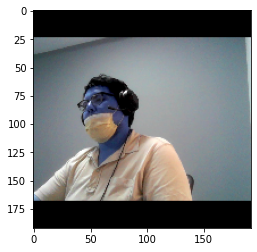

In [44]:
plt.imshow(tf.cast(np.squeeze(img), dtype=tf.int32))

In [45]:
img = frame.copy()

In [46]:
img.shape

(480, 640, 3)

In [47]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3]),
  'shape_signature': array([ 1,  1, 17,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [48]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    # Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [49]:
right_eye = keypoints_with_scores[0][0][2]
left_elbow = keypoints_with_scores[0][0][7]

In [50]:
shaped = np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]['index']), [480,640,1]))

In [51]:
for kp in shaped:
    ky, kx, kp_conf = kp
    print(int(ky), int(kx), kp_conf)

225 158 0.57081139087677
200 186 0.5967543125152588
207 147 0.6115233898162842
214 268 0.546069860458374
215 174 0.531326174736023
309 377 0.8052270412445068
322 137 0.5481497049331665
359 412 0.006494093686342239
404 25 0.2874242067337036
300 257 0.010789615102112293
337 105 0.06785749644041061
480 325 0.006329599767923355
478 145 0.04640057682991028
395 288 0.005833203438669443
356 84 0.026937415823340416
405 14 0.01123582199215889
407 15 0.0161777101457119


# 3. Draw Keypoints

In [52]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

# 4. Draw Edges

In [53]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [54]:
shaped[0], shaped[1]


(array([225.25139809, 158.11948776,   0.57081139]),
 array([200.58950901, 186.79670334,   0.59675431]))

In [55]:
for edge, color in EDGES.items():
    p1, p2 = edge
    y1, x1, c1 = shaped[p1]
    y2, x2, c2 = shaped[p2]
    print((int(x2), int(y2)))

(186, 200)
(147, 207)
(268, 214)
(174, 215)
(377, 309)
(137, 322)
(412, 359)
(257, 300)
(25, 404)
(105, 337)
(137, 322)
(325, 480)
(145, 478)
(145, 478)
(288, 395)
(14, 405)
(84, 356)
(15, 407)


In [56]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)